In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [9]:
DATA_PATH = './healthy_meal_plans.csv'

df = pd.read_csv(DATA_PATH)
display(df.describe())

,num_ingredients,calories,prep_time,protein,fat,carbs,vegan,vegetarian,keto,paleo,gluten_free,mediterranean,is_healthy
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.489818,0.504149,0.486480,0.505704,0.506822,0.507081,0.334000,0.574000,0.366000,0.388000,0.528000,0.302000,0.094000
std,0.305054,0.290267,0.293234,0.291046,0.282906,0.292257,0.472112,0.494989,0.482192,0.487783,0.499715,0.459585,0.292121
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.272727,0.231818,0.220000,0.236392,0.257945,0.251489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.454545,0.509091,0.490000,0.521935,0.516733,0.510196,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.727273,0.751364,0.740000,0.764155,0.751306,0.746904,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Распределение классов:


is_healthy
0    453
1     47
Name: count, dtype: int64

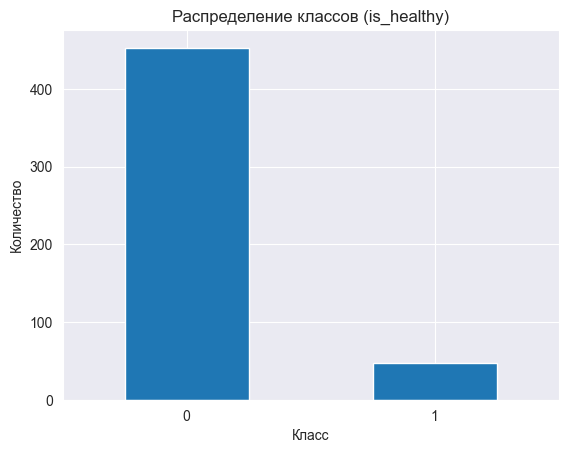

In [10]:
target_col = 'is_healthy'

class_counts = df[target_col].value_counts(dropna=False).sort_index()
print('Распределение классов:')
display(class_counts)
ax = class_counts.plot(kind='bar', title='Распределение классов (is_healthy)', rot=0)
ax.set_xlabel('Класс')
ax.set_ylabel('Количество')
plt.show()

In [16]:
drop_cols = []
if 'meal_name' in df.columns:
    drop_cols.append('meal_name')

X = df.drop(columns=[target_col] + drop_cols)
y = df[target_col].astype(int)

print('Признаки:', list(X.columns))

# Разделим на train/test со стратификацией по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y if y.nunique() > 1 else None
)
print('Train shape:', X_train.shape, '| Test shape:', X_test.shape)

# Определим типы признаков
num_cols = [c for c in X_train.columns if np.issubdtype(X_train[c].dtype, np.number)]
binary_like_cols = []
for c in num_cols:
    vals = pd.unique(X_train[c].dropna())
    if set(vals).issubset({0, 1}):
        binary_like_cols.append(c)
cont_cols = [c for c in num_cols if c not in binary_like_cols]

print('Непрерывные признаки:', cont_cols)
print('Бинарные (индикаторы):', binary_like_cols)

# Импутация пропусков: медиана для непрерывных, наиболее частое для бинарных
num_imputer = SimpleImputer(strategy='median')
bin_imputer = SimpleImputer(strategy='most_frequent')

X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

if cont_cols:
    X_train_imputed[cont_cols] = num_imputer.fit_transform(X_train[cont_cols])
    X_test_imputed[cont_cols] = num_imputer.transform(X_test[cont_cols])
if binary_like_cols:
    X_train_imputed[binary_like_cols] = bin_imputer.fit_transform(X_train[binary_like_cols])
    X_test_imputed[binary_like_cols] = bin_imputer.transform(X_test[binary_like_cols])

# Клиппинг выбросов по IQR для непрерывных признаков (границы считаем по train)
X_train_clean = X_train_imputed.copy()
X_test_clean = X_test_imputed.copy()

if cont_cols:
    Q1 = X_train_imputed[cont_cols].quantile(0.15)
    Q3 = X_train_imputed[cont_cols].quantile(0.85)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    for c in cont_cols:
        X_train_clean[c] = X_train_imputed[c].clip(lower=lower[c], upper=upper[c])
        X_test_clean[c]  = X_test_imputed[c].clip(lower=lower[c],  upper=upper[c])

# Стандартизация непрерывных признаков (fit на train, transform на test)
X_train_final = X_train_clean.copy()
X_test_final = X_test_clean.copy()

scaler = None
if cont_cols:
    scaler = StandardScaler()
    X_train_final[cont_cols] = scaler.fit_transform(X_train_clean[cont_cols])
    X_test_final[cont_cols] = scaler.transform(X_test_clean[cont_cols])

print('Готово: данные очищены и масштабированы.')
display(X_train_final.head())

Признаки: ['num_ingredients', 'calories', 'prep_time', 'protein', 'fat', 'carbs', 'vegan', 'vegetarian', 'keto', 'paleo', 'gluten_free', 'mediterranean']
Train shape: (375, 12) | Test shape: (125, 12)
Непрерывные признаки: ['num_ingredients', 'calories', 'prep_time', 'protein', 'fat', 'carbs']
Бинарные (индикаторы): ['vegan', 'vegetarian', 'keto', 'paleo', 'gluten_free', 'mediterranean']
Готово: данные очищены и масштабированы.


,num_ingredients,calories,prep_time,protein,fat,carbs,vegan,vegetarian,keto,paleo,gluten_free,mediterranean
181,-0.759059,0.208795,1.744854,0.003786,-0.972351,-1.139828,0,0,0,0,1,0
241,0.131391,0.472573,0.859994,1.234619,-1.159979,0.636908,1,1,0,0,0,1
33,0.725024,0.384647,-1.590389,0.624327,0.504596,-0.975472,0,0,1,0,1,0
160,0.428208,-1.669052,0.723861,0.718342,-0.739386,0.202374,0,0,1,1,1,1
262,-0.462243,1.295308,1.268391,1.216111,-1.021186,-1.418039,1,1,0,1,1,0


In [11]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
svm_rbf = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE)
cart = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

models = {
    'LogisticRegression': log_reg,
    'SVM_RBF': svm_rbf,
    'CART_Tree': cart
}

for name, model in models.items():
    model.fit(X_train_final, y_train)
    print(f'Обучена модель: {name}')

print('Все модели обучены.')

Обучена модель: LogisticRegression
Обучена модель: SVM_RBF
Обучена модель: CART_Tree
Все модели обучены.


Метрики на тестовой выборке:


,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.616,0.154,0.667,0.250,0.654
SVM_RBF,0.896,0.476,0.833,0.606,0.950
CART_Tree,0.968,0.833,0.833,0.833,0.908



===== Classification report: LogisticRegression =====
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       113
           1       0.15      0.67      0.25        12

    accuracy                           0.62       125
   macro avg       0.55      0.64      0.50       125
weighted avg       0.87      0.62      0.69       125


===== Classification report: SVM_RBF =====
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       113
           1       0.48      0.83      0.61        12

    accuracy                           0.90       125
   macro avg       0.73      0.87      0.77       125
weighted avg       0.93      0.90      0.91       125


===== Classification report: CART_Tree =====
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       113
           1       0.83      0.83      0.83        12

    accuracy                         

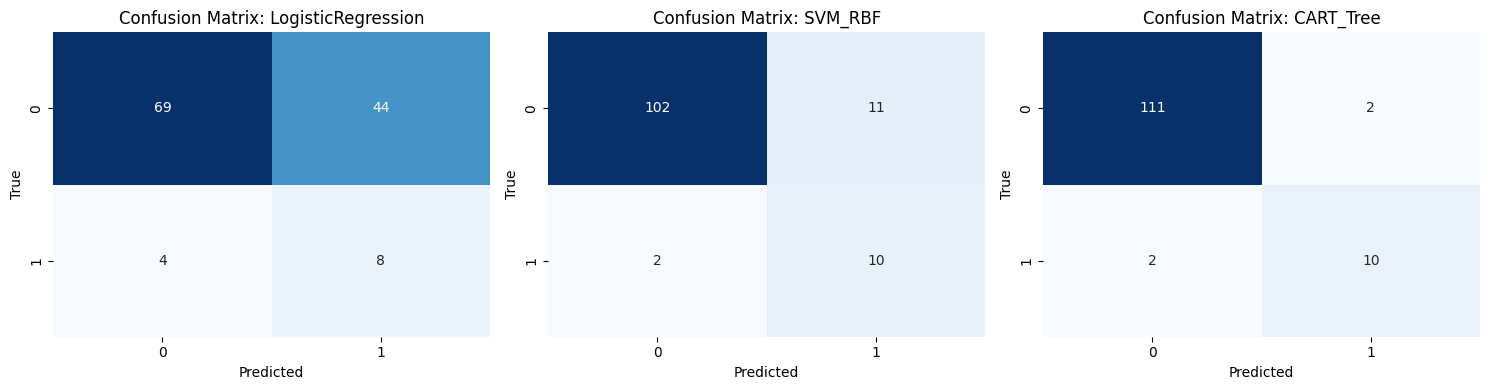

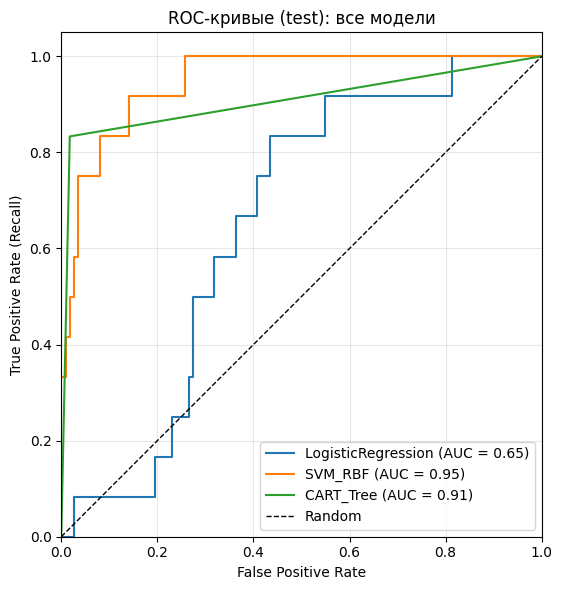

In [ ]:
def evaluate_model(model, X_te, y_te, model_name='model'):
    y_pred = model.predict(X_te)
    # Вероятности для ROC-AUC (для некоторых моделей может понадобиться decision_function)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, 'decision_function'):
        # Приведем к [0,1] через сигмоиду для совместимости ROC-AUC
        scores = model.decision_function(X_te)
        y_score = 1 / (1 + np.exp(-scores))
    else:
        # Фоллбэк: используем предсказанные классы как вероятности (хуже для ROC-AUC)
        y_score = y_pred.astype(float)

    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_te, y_pred),
        'precision': precision_score(y_te, y_pred, zero_division=0),
        'recall': recall_score(y_te, y_pred, zero_division=0),
        'f1': f1_score(y_te, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_te, y_score) if y_te.nunique() > 1 else np.nan
    }
    cm = confusion_matrix(y_te, y_pred)
    report = classification_report(y_te, y_pred, zero_division=0)
    return metrics, cm, report, y_score

results = []
cms = {}
reports = {}
scores = {}

for name, model in models.items():
    m, cm, rep, y_score = evaluate_model(model, X_test_final, y_test, name)
    results.append(m)
    cms[name] = cm
    reports[name] = rep
    scores[name] = y_score

metrics_df = pd.DataFrame(results).set_index('model')
print('Метрики на тестовой выборке:')
display(metrics_df.style.format('{:.3f}'))

for name, rep in reports.items():
    print(f'\n===== Classification report: {name} =====')
    print(rep)

# Визуализация матриц ошибок
fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 4))
if len(models) == 1:
    axes = [axes]
for ax, (name, cm) in zip(axes, cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix: {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.show()

# ROC-кривые
fig, ax = plt.subplots(figsize=(7, 6))
for name, y_score in scores.items():
    if y_test.nunique() > 1:
        RocCurveDisplay.from_predictions(y_test, y_score, name=name, ax=ax)

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('ROC-кривые (test): все модели')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# accuracy — доля всех верных предсказаний.
# precision (для класса 1) — среди всех предсказаний “1” какая доля действительно “1”.
# recall (для класса 1) — какая доля истинных “1” найдена.
# f1 — гармоническое среднее precision и recall.
# roc_auc — качество ранжирования вероятностей